In [1]:
# Figures S1 S2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import numpy as np
import seaborn as sns
from collections import defaultdict
import pandas as pd
import string

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, *args, **kwargs):
            self.set_thetagrids(np.degrees(theta), labels, *args, **kwargs)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def create_colors_list():
    colors_list = []
    for color in plt.cm.tab10(np.linspace(0, 1, 10))[:-1]:
        colors_list.append(tuple(color))
    colors_list.append("black")
    for color in plt.cm.Set2(np.linspace(0, 1, 8)):
        colors_list.append(tuple(color))
    for color in plt.cm.Set3(np.linspace(0, 1, 12)):
        colors_list.append(tuple(color))
    return colors_list



In [5]:
def get_data():
    DATASET_TO_PATH = {
        "CAMI Gt" : "../results/amber_cami_gt_all/results.tsv",
        "CAMI Airways" : "../results/amber_cami_airways_all/results.tsv",
        "CAMI Skin" : "../results/amber_cami_skin_all/results.tsv",
        "CAMI Mouse gut" : "../results/amber_cami_mousegut_all/results.tsv",
    }


    d_comb = defaultdict(list)
    modes= [ 'COMEBinfilterminszie200000',
             'SemiBin2',
             'SemiBin1',
             'MetaDecoder',
             'CLMB',
             'VAMB_v413',
             'MetaBAT',
             'MaxBin',
             'CONCOCT']
    combs = ["CAMI Gt", "CAMI Airways", "CAMI Skin", "CAMI Mouse gut"]

    for comb in combs:
        cur_dataname, cur_q = comb[: comb.rfind("_")], comb[comb.rfind("_") + 1 :]
        f1score_list = []
        ari_list = []
        percentage_list = []
        accuracy_list = []
        # labels = ["F1 score (bp)", "Adjusted Rand index (bp)", "Percentage of binned bp","Accuracy (bp)"]
        for mode in modes:
            cur_data = pd.read_csv(DATASET_TO_PATH[comb], index_col=33,sep='\t', header=0)
            f1score_list.append(cur_data.loc[mode]["F1 score (bp)"])
            ari_list.append(cur_data.loc[mode]["Adjusted Rand index (bp)"])
            percentage_list.append(cur_data.loc[mode]["Percentage of binned bp"])
            accuracy_list.append(cur_data.loc[mode]["Accuracy (bp)"])

        d_comb[comb].append(f1score_list)
        d_comb[comb].append(ari_list)
        d_comb[comb].append(percentage_list)
        d_comb[comb].append(accuracy_list)

    return modes, combs, d_comb


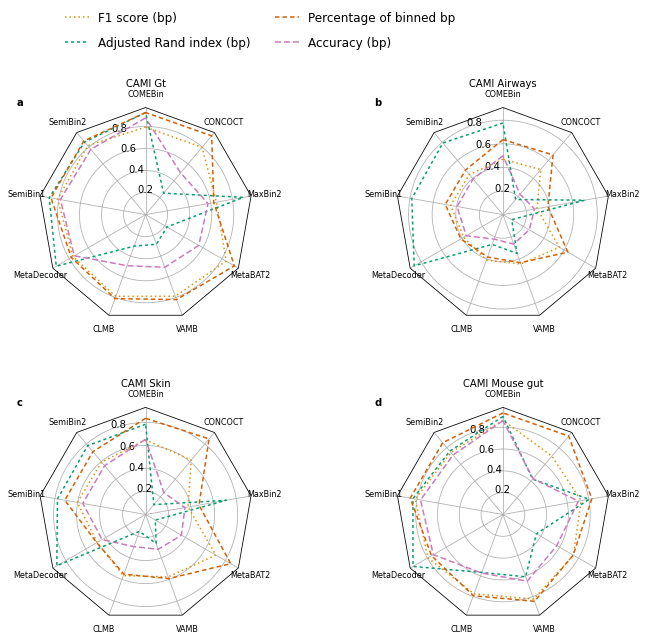

In [6]:
theta = radar_factory(9, frame='polygon')
colors = [sns.color_palette('colorblind')[x] for x in [1, 2, 3, 4]]

fig, axes = plt.subplots(figsize=(17, 17), nrows=2, ncols=2, subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.05, hspace=0.4, top=0.87, bottom=0.45,left=0.3, right=0.87)

modes, combs, d_comb = get_data()

annot = list(string.ascii_lowercase)
i=0
for ax, comb in zip(axes.flat, combs):
    it = 1
    for d, color in zip(d_comb[comb], colors):

        ax.plot(theta, d, color=color, linewidth=1.5, dashes=(it, 2))
        it += 1

    labels = ["F1 score (bp)", "Adjusted Rand index (bp)", "Percentage of binned bp","Accuracy (bp)"]
    ax.set_title(comb, size=10, position=(0.5, 1.15), horizontalalignment='center', verticalalignment='center')
    ax.set_varlabels([ 'COMEBin',
                              'SemiBin2',
                              'SemiBin1',
                              'MetaDecoder',
                              'CLMB',
                              'VAMB',
                              'MetaBAT2',
                              'MaxBin2',
                              'CONCOCT'], fontsize=8)
    ax.text(-0.1, 1.05, annot[i], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    i+=1
    ax = axes[0, 0]


    ax.legend(labels, loc=(0.1, 1.25), labelspacing=1, fontsize=12, ncol=2, frameon=False)

plt.savefig("./figures/cami_toy_radar_4_tool.pdf", dpi=300, format='pdf', bbox_inches='tight')





In [9]:
def get_data():
    DATASET_TO_PATH = {
        "Plant-associated GSA": "../results/amber_plant_gsa_all_noplasmids/results.tsv",
        "Strain madness GSA": "../results/amber_strain_madness_gsa_all/results.tsv",
        "Strain madness MA": "../results/amber_strain_madness_ma_all/results.tsv",
        "Plant-associated MA": "../results/amber_plant_ma_all_noplasmids/results.tsv",
        "Marine GSA": "../results/amber_marine_gsa_all_nocircular/results.tsv",
        "Marine MA": "../results/amber_marine_ma_nocircular/results.tsv",
    }


    d_comb = defaultdict(list)
    modes= [ 'COMEBin(filter200000)',
             'SemiBin2',
             'SemiBin1',
             'MetaDecoder',
             'CLMB',
             'VAMB_v413',
             'MetaBAT',
             'MaxBin',
             'CONCOCT']
    combs = ["Marine GSA", "Marine MA", "Plant-associated GSA", "Plant-associated MA","Strain madness GSA","Strain madness MA"]

    for comb in combs:
        cur_dataname, cur_q = comb[: comb.rfind("_")], comb[comb.rfind("_") + 1 :]
        f1score_list = []
        ari_list = []
        percentage_list = []
        accuracy_list = []

        # labels = ["F1 score (bp)", "Adjusted Rand index (bp)", "Percentage of binned bp","Accuracy (bp)"]
        for mode in modes:
            cur_data = pd.read_csv(DATASET_TO_PATH[comb], index_col=33,sep='\t', header=0)
            f1score_list.append(cur_data.loc[mode]["F1 score (bp)"])
            ari_list.append(cur_data.loc[mode]["Adjusted Rand index (bp)"])
            percentage_list.append(cur_data.loc[mode]["Percentage of binned bp"])
            accuracy_list.append(cur_data.loc[mode]["Accuracy (bp)"])

        d_comb[comb].append(f1score_list)
        d_comb[comb].append(ari_list)
        d_comb[comb].append(percentage_list)
        d_comb[comb].append(accuracy_list)

    return modes, combs, d_comb




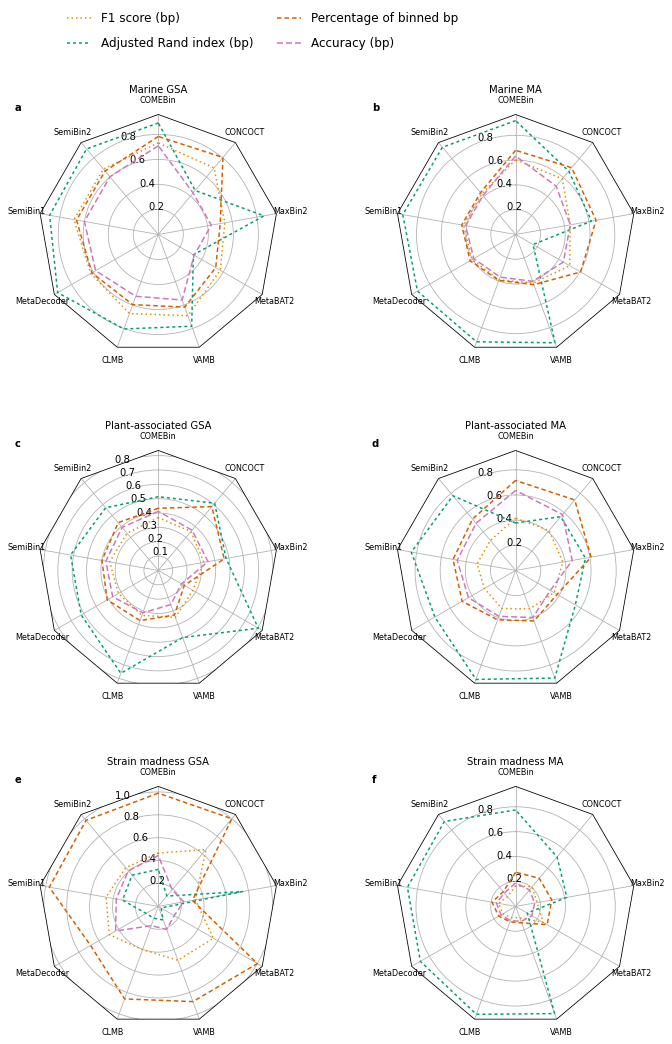

In [11]:
theta = radar_factory(9, frame='polygon')
colors = [sns.color_palette('colorblind')[x] for x in [1, 2, 3, 4]]

fig, axes = plt.subplots(figsize=(17, 17), nrows=3, ncols=2, subplot_kw=dict(projection='radar'))

fig.subplots_adjust(wspace=0.05, hspace=0.4, top=0.87,left=0.3, right=0.87)

modes, combs, d_comb = get_data()

annot = list(string.ascii_lowercase)
i=0
for ax, comb in zip(axes.flat, combs):
    it = 1
    for d, color in zip(d_comb[comb], colors):
        ax.plot(theta, d, color=color, linewidth=1.5, dashes=(it, 2))
        it += 1

    labels = ["F1 score (bp)", "Adjusted Rand index (bp)", "Percentage of binned bp","Accuracy (bp)"]
    ax.set_title(comb, size=10, position=(0.5, 1.15), horizontalalignment='center', verticalalignment='center')
    ax.set_varlabels([ 'COMEBin',
                              'SemiBin2',
                              'SemiBin1',
                              'MetaDecoder',
                              'CLMB',
                              'VAMB',
                              'MetaBAT2',
                              'MaxBin2',
                              'CONCOCT'], fontsize=8)
    ax.text(-0.1, 1.05, annot[i], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    i+=1
    ax = axes[0, 0]


    ax.legend(labels, loc=(0.1, 1.25), labelspacing=1, fontsize=12, ncol=2, frameon=False)

plt.savefig("./figures/cami2_radar_4_tool.pdf", dpi=300, format='pdf', bbox_inches='tight')







In [12]:
## Figure S3

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'



In [29]:
def get_known_unknown(bac_path,  arr_path = None):
    bac = pd.read_csv(bac_path,
                      '\t').values

    known_list = []
    unknown_list = []
    print(bac.shape)
    for temp in bac:
        split = temp[1].split(';')
        if len(split) == 1:#"deal with unclassified bacteria"
            continue
        species = split[-1]

        if species != 's__':
            if species[0:3] != 's__':
                print('error')
                print(species)
            known_list.append(species)
        else:
            unknown_list.append(species)

    if arr_path is not None:
        arr = pd.read_csv(arr_path,
                          '\t').values
        print(arr.shape)
        for temp in arr:
            split = temp[1].split(';')
            species = split[-1]

            if species != 's__':
                if species[0:3] != 's__':
                    print('error')
                known_list.append(species)
            else:
                unknown_list.append(species)

    return known_list, unknown_list


In [30]:
def plot_comparison_known_unknown(dataset = 'watergroup2', y_label = None,output = None):
    if dataset == 'watergroup2' or dataset == 'watergroup3':
        comebin_known, comebin_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/COMEBin/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset))

        Metabat2_known, Metabat2_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/metabat2_bins/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset))
    if dataset == 'MetaHIT_reads' or dataset =='MetaHIT_reads_coassembly_10sample':
        comebin_known, comebin_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/COMEBin/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset),
                                                           '../results/real_data/gtdb_res/{0}/COMEBin/checkm2_quality_5005_gtdbtk_output/gtdbtk.ar53.summary.tsv'.format(dataset))

        Metabat2_known, Metabat2_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/metabat2_bins/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset),
                                                             '../results/real_data/gtdb_res/{0}/metabat2_bins/checkm2_quality_5005_gtdbtk_output/gtdbtk.ar53.summary.tsv'.format(dataset))


    subset = np.array([[len(Metabat2_known), len(Metabat2_unknown)], [len(comebin_known), len(comebin_unknown)]])
    subset = pd.DataFrame(subset, index=['MetaBAT2', 'COMEBin'],
                          columns=['Known', 'Unknown'])
    print(subset)
    ax = subset.plot(kind="bar", stacked=True,
                     legend=False, figsize=(3, 4), color = ['#1b9e77', '#ec7014',])

    ax.legend(['Known', 'Unknown'],
              loc='upper left', fontsize=8)
    ax.set_yticks(ticks=y_label)
    ax.set_yticklabels(labels=y_label, fontsize=10, color='black')

    ax.set_xticklabels(labels=['MetaBAT2', 'COMEBin'], rotation=0,
                       minor=False, fontsize=10, color='black')
    ax.set_ylabel('Number of species', fontsize=10, color='black')

    plt.savefig(output, dpi=300, bbox_inches='tight')


/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  comebin_known, comebin_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/COMEBin/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset))
/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:5: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  Metabat2_known, Metabat2_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/metabat2_bins/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset))


(103, 20)
(94, 20)
          Known  Unknown
MetaBAT2     28       65
COMEBin      35       66


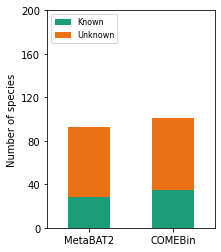

In [31]:
plot_comparison_known_unknown(dataset='watergroup2',y_label=[0,40,80,120,160,200], output='./figures/watergroup2_taxi_known_unknown.pdf')


/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  comebin_known, comebin_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/COMEBin/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset))
/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:5: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  Metabat2_known, Metabat2_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/metabat2_bins/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset))


(125, 20)
(104, 20)
          Known  Unknown
MetaBAT2     30       74
COMEBin      38       85


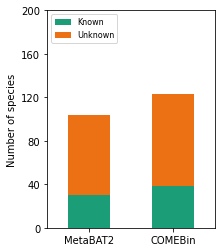

In [32]:
plot_comparison_known_unknown(dataset='watergroup3', y_label=[0,40,80,120,160,200], output='./figures/watergroup3_taxi_known_unknown.pdf')


/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  comebin_known, comebin_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/COMEBin/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset),
/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  Metabat2_known, Metabat2_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/metabat2_bins/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset),


(356, 20)
(3, 20)
(318, 20)
(3, 20)
          Known  Unknown
MetaBAT2    321        0
COMEBin     356        2


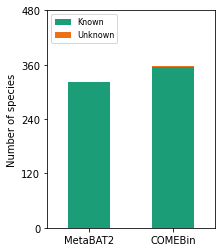

In [33]:
plot_comparison_known_unknown(dataset='MetaHIT_reads', y_label=[0,120,240,360,480], output='./figures/MetaHIT_reads_taxi_known_unknown.pdf')


/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  comebin_known, comebin_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/COMEBin/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset),
/var/folders/p8/vsgrg7lx105383v55gkd_wf40000gn/T/ipykernel_54774/4068132210.py:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  Metabat2_known, Metabat2_unknown = get_known_unknown('../results/real_data/gtdb_res/{0}/metabat2_bins/checkm2_quality_5005_gtdbtk_output/gtdbtk.bac120.summary.tsv'.format(dataset),


(88, 20)
(1, 20)
(76, 20)
(1, 20)
          Known  Unknown
MetaBAT2     77        0
COMEBin      89        0


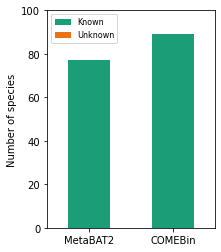

In [34]:
plot_comparison_known_unknown(dataset='MetaHIT_reads_coassembly_10sample',y_label=[0, 20, 40, 60, 80, 100],output='./figures/MetaHIT_reads_coassembly_10sample_taxi_known_unknown.pdf')


In [36]:
## Figures S4, S5

In [37]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax,fraction=0.02, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    ax.set_yticklabels(labels=row_labels, fontsize=7)  #

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts




def calculate_counts(amber_res_file):
    metric = pd.read_csv(amber_res_file, sep='\t')

    tools = list(np.unique(metric['Tool']))

    dic = {}
    for tool in tools:
        dic[tool] = metric[(metric['Tool'] == tool) &
                           (2 * metric['precision_bp'].astype(float) * metric['recall_bp'].astype(float) /
                            (metric['precision_bp'].astype(float) + metric['recall_bp'].astype(float)) > float(0.9))]

    count = {}
    for tool in tools:
        count[tool] = len(dic[tool])

    return count

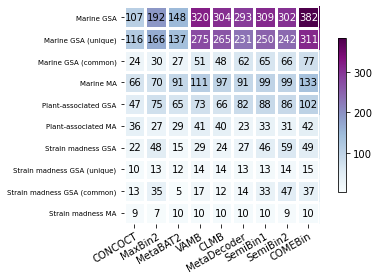

In [38]:
DATASET_TO_PATH = {
    "Plant-associated GSA": "../results/amber_plant_gsa_all_noplasmids/bin_metrics.tsv",
    "Strain madness GSA": "../results/amber_strain_madness_gsa_all/bin_metrics.tsv",
    "Strain madness GSA (unique)": "../results/amber_strain_madness_gsa_all_unique/bin_metrics.tsv",
    "Strain madness GSA (common)": "../results/amber_strain_madness_gsa_all_common/bin_metrics.tsv",
    "Strain madness MA": "../results/amber_strain_madness_ma_all/bin_metrics.tsv",
    "Plant-associated MA": "../results/amber_plant_ma_all_noplasmids/bin_metrics.tsv",
    "Marine GSA": "../results/amber_marine_gsa_all_nocircular/bin_metrics.tsv",
    "Marine GSA (unique)": "../results/amber_marine_gsa_all_nocircular_unique/bin_metrics.tsv",
    "Marine GSA (common)" : "../results/amber_marine_gsa_all_nocircular_common/bin_metrics.tsv",
    "Marine MA": "../results/amber_marine_ma_nocircular/bin_metrics.tsv",
}

d_comb = defaultdict(list)
methods= [ 'COMEBin(filter200000)',
         'SemiBin2',
         'SemiBin1',
         'MetaDecoder',
         'CLMB',
         'VAMB_v413',
         'MetaBAT',
         'MaxBin',
         'CONCOCT'][::-1]

datasets = [
    "Marine GSA","Marine GSA (unique)","Marine GSA (common)","Marine MA",
    "Plant-associated GSA","Plant-associated MA",
    "Strain madness GSA", "Strain madness GSA (unique)","Strain madness GSA (common)","Strain madness MA"]

for dataset in datasets:
    f1score_number_list = []
    cur_data = calculate_counts(DATASET_TO_PATH[dataset])
    for method in methods:
        f1score_number_list.append(cur_data[method])

    d_comb[dataset]= f1score_number_list

sim_res = np.array([d_comb[dataset] for dataset in datasets])


fig, ax = plt.subplots()


binners = ["CONCOCT","MaxBin2","MetaBAT2","VAMB","CLMB","MetaDecoder","SemiBin1","SemiBin2","COMEBin"]

im, cbar = heatmap(sim_res, datasets, binners, ax=ax,
                   cmap="BuPu")

texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
#plt.show()
plt.savefig("./figures/f1scorebiggerthan0.9_sim_holdout_addcommonunique.pdf", dpi=300)



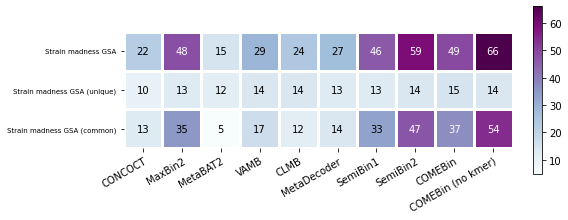

In [39]:
DATASET_TO_PATH = {
    "Strain madness GSA": "../results/amber_strain_madness_gsa_all/bin_metrics.tsv",
    "Strain madness GSA (unique)": "../results/amber_strain_madness_gsa_all_unique/bin_metrics.tsv",
    "Strain madness GSA (common)": "../results/amber_strain_madness_gsa_all_common/bin_metrics.tsv",
}

d_comb = defaultdict(list)
methods= [ 'COMEBin_filter200000_nokmer',
           'COMEBin(filter200000)',
           'SemiBin2',
           'SemiBin1',
           'MetaDecoder',
           'CLMB',
           'VAMB_v413',
           'MetaBAT',
           'MaxBin',
           'CONCOCT'][::-1]

datasets = [
    "Strain madness GSA", "Strain madness GSA (unique)","Strain madness GSA (common)"]

for dataset in datasets:
    f1score_number_list = []
    cur_data = calculate_counts(DATASET_TO_PATH[dataset])
    for method in methods:
        f1score_number_list.append(cur_data[method])

    d_comb[dataset]= f1score_number_list

sim_res = np.array([d_comb[dataset] for dataset in datasets])


fig, ax = plt.subplots(figsize=(8, 4))


binners = ["CONCOCT","MaxBin2","MetaBAT2","VAMB","CLMB","MetaDecoder","SemiBin1","SemiBin2","COMEBin","COMEBin (no kmer)"]

im, cbar = heatmap(sim_res, datasets, binners, ax=ax,
                   cmap="BuPu")

texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
#plt.show()
plt.savefig("./figures/f1scorebiggerthan0.9_COMEBin_nokmer.pdf", dpi=300)



In [40]:
## Figure S6

In [41]:
import pandas as pd
import os
import matplotlib.pyplot as plt


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

color_map = ['#014f3f','#01665e', '#5da8a1', '#80cdc1', '#c7eae5']

def get_number_of_genomes_per_completeness_checkm2(checkm2_res_file, return_pandas=False):
    # checkm2_res_file='/mnt/data/wzy/comebin_paper_res/STEC/checkm2_res_all_stat_res.tsv'
    metric = pd.read_csv(checkm2_res_file,index_col=0, sep='\t')
    table = {}
    for bin_method in list(metric.index):
        if bin_method != 'Method':
            com_90_pur_95 = int(metric['num_905'][bin_method])
            com_80_pur_95 = int(metric['num_805'][bin_method]) - com_90_pur_95
            com_70_pur_95 = int(metric['num_705'][bin_method]) - com_90_pur_95 - com_80_pur_95
            com_60_pur_95 = int(metric['num_605'][bin_method]) - com_90_pur_95 - com_80_pur_95 - com_70_pur_95
            com_50_pur_95 = int(metric['num_505'][bin_method]) - com_90_pur_95 - com_80_pur_95 - com_70_pur_95 - com_60_pur_95
            table[bin_method.split('/')[0]]= [com_90_pur_95, com_80_pur_95, com_70_pur_95, com_60_pur_95, com_50_pur_95]

    if return_pandas:
        return pd.DataFrame(table, index=[90,80,70,60,50]).T
    return table


In [47]:
def plot_bar_realdata_sum(sample_list, data_path, add_legend=True,y_label = None,title = None, output = None):
    for sample in sample_list:
        checkm2_res_file=data_path+'/'+sample+'/checkm2_res_all_stat_res.tsv.clean.tsv'
        data = get_number_of_genomes_per_completeness_checkm2(checkm2_res_file, return_pandas=True)

        if 'concoct_bins_checkm2_output' in data.index:
            data = data.rename(index={'concoct_bins_checkm2_output': 'CONCOCT'})
        if 'maxbin2_bins_checkm2_output' in data.index:
            data = data.rename(index={'maxbin2_bins_checkm2_output': 'MaxBin2'})
        if 'metabat2_bins_checkm2_output' in data.index:
            data = data.rename(index={'metabat2_bins_checkm2_output': 'MetaBAT2'})
        if 'concoct_bins_checkm2_quality_report.tsv' in data.index:
            data = data.rename(index={'concoct_bins_checkm2_quality_report.tsv': 'CONCOCT'})
        if 'maxbin2_bins_checkm2_quality_report.tsv' in data.index:
            data = data.rename(index={'maxbin2_bins_checkm2_quality_report.tsv': 'MaxBin2'})
        if 'metabat2_bins_checkm2_quality_report.tsv' in data.index:
            data = data.rename(index={'metabat2_bins_checkm2_quality_report.tsv': 'MetaBAT2'})
        if 'vamb_v413_m200000' in data.index:
            data = data.rename(index={'vamb_v413_m200000': 'VAMB'})
        if 'clmb_m200000' in data.index:
            data = data.rename(index={'clmb_m200000': 'CLMB'})
        if 'metadecoder' in data.index:
            data = data.rename(index={'metadecoder': 'MetaDecoder'})
        if 'semibin2_Easy_coassemly_mode' in data.index:
            data = data.rename(index={'semibin2_Easy_coassemly_mode': 'SemiBin2'})
        if 'semibin_Easy_coassemly_mode_v1.0.0_default' in data.index:
            data = data.rename(index={'semibin_Easy_coassemly_mode_v1.0.0_default': 'SemiBin1'})
        if 'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric' in data.index:
            data = data.rename(index={'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric': 'COMEBin'})

        subset = data.loc[[
            'COMEBin',
            'SemiBin2',
            'SemiBin1',
            'MetaDecoder',
            'CLMB',
            'VAMB',
            'MetaBAT2',
            'MaxBin2',
            'CONCOCT']]

        subset = subset[[90,80,70,60,50]]
        print(subset)
        if sample==sample_list[0]:
            subset_sum=subset
        else:
            subset_sum +=subset
    subset = subset_sum
    print(subset_sum)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=15, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=15, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=15, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()
    plt.close()



In [43]:
#MetaHIT 10-sample; single-sample binning

             90  80  70  60  50
COMEBin       9   1   3   3   1
SemiBin2      5   2   0   2   3
SemiBin1      5   4   0   2   1
MetaDecoder   6   2   2   0   2
CLMB          3   2   0   0   1
VAMB          4   1   0   2   1
MetaBAT2      4   4   1   2   3
MaxBin2       5   0   0   2   1
CONCOCT       5   1   0   1   2
             90  80  70  60  50
COMEBin       0   0   1   1   1
SemiBin2      0   0   0   0   0
SemiBin1      0   0   0   0   0
MetaDecoder   0   0   0   0   0
CLMB          0   0   0   0   0
VAMB          0   0   0   0   0
MetaBAT2      0   0   0   0   1
MaxBin2       0   0   0   0   0
CONCOCT       0   0   1   0   0
             90  80  70  60  50
COMEBin      11   5   0   1   3
SemiBin2      4   6   3   1   2
SemiBin1      5   5   2   4   0
MetaDecoder   6   6   1   2   0
CLMB          6   3   1   2   1
VAMB          5   4   3   1   1
MetaBAT2      7   6   1   3   1
MaxBin2       6   2   1   1   1
CONCOCT       8   3   0   2   1
             90  80  70  60  50
COMEBin 

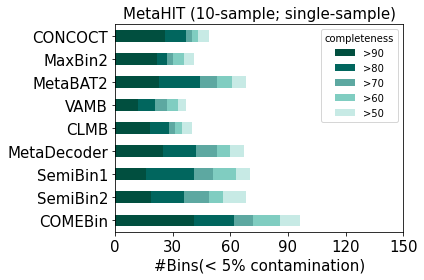

In [48]:
sample_list=['ERR011101','ERR011113','ERR011120','ERR011132','ERR011152',
             'ERR011172','ERR011223','ERR011284','ERR011295','ERR011325']

data_path='../results/real_data/MetaHIT_reads_10sample_single_sample'
output='./figures/MetaHIT_reads_10sample_singlesample_sum_checkm2_plot_all.pdf'
plot_bar_realdata_sum(sample_list, data_path,y_label=[0, 30, 60, 90, 120, 150], 
                                       title='MetaHIT (10-sample; single-sample)', output = output)


In [49]:
#MetaHIT 10-sample; multi-sample binning

             90  80  70  60  50
COMEBin       9   3   2   3   1
SemiBin2      6   3   2   0   1
SemiBin1      6   3   0   1   2
MetaDecoder   6   0   3   1   1
CLMB          2   5   0   3   0
VAMB          5   2   1   1   2
MetaBAT2      5   4   0   2   2
MaxBin2       6   2   0   2   1
CONCOCT       7   4   2   3   0
             90  80  70  60  50
COMEBin       0   0   3   1   0
SemiBin2      0   0   0   0   0
SemiBin1      0   0   0   0   0
MetaDecoder   0   0   0   0   1
CLMB          0   0   0   0   0
VAMB          0   0   0   0   1
MetaBAT2      0   0   1   2   1
MaxBin2       0   1   0   0   0
CONCOCT       0   0   2   1   0
             90  80  70  60  50
COMEBin       8   7   3   1   3
SemiBin2      6   6   1   3   0
SemiBin1      6   7   1   3   0
MetaDecoder   3   4   3   3   1
CLMB          4   4   1   1   0
VAMB          3   6   3   3   2
MetaBAT2      9   3   1   2   0
MaxBin2       9   3   1   1   1
CONCOCT      12   2   1   1   3
             90  80  70  60  50
COMEBin 

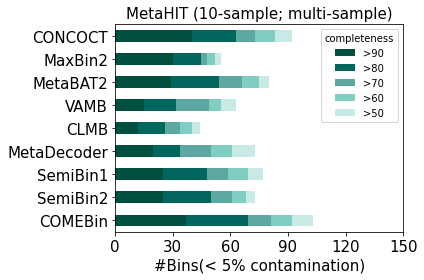

In [51]:
sample_list=['ERR011101','ERR011113','ERR011120','ERR011132','ERR011152',
             'ERR011172','ERR011223','ERR011284','ERR011295','ERR011325']

data_path='../results/real_data/MetaHIT_reads_10sample_multi_sample'
output='./figures/MetaHIT_reads_10sample_multisample_sum_checkm2_plot_all.pdf'
plot_bar_realdata_sum(sample_list, data_path,y_label=[0, 30, 60, 90, 120, 150],
                      title='MetaHIT (10-sample; multi-sample)', output = output)


In [52]:
# watergroup2_singlesample

             90  80  70  60  50
COMEBin       6   4   2   6   4
SemiBin2      5   5   3   2   5
SemiBin1      5   4   4   3   5
MetaDecoder   4   6   4   5   3
CLMB          4   1   0   4   2
VAMB          3   0   3   2   0
MetaBAT2      8   2   2   3   3
MaxBin2       2   0   1   2   3
CONCOCT       3   3   1   1   3
             90  80  70  60  50
COMEBin       4   5   2   1   3
SemiBin2      3   3   5   3   4
SemiBin1      3   3   5   3   0
MetaDecoder   4   4   5   3   2
CLMB          0   2   2   0   3
VAMB          0   0   0   4   1
MetaBAT2      5   3   3   3   2
MaxBin2       0   0   0   1   1
CONCOCT       0   1   2   0   1
             90  80  70  60  50
COMEBin       2   4   0   3   4
SemiBin2      0   3   3   1   5
SemiBin1      0   2   4   4   1
MetaDecoder   0   2   4   4   4
CLMB          0   0   1   0   0
VAMB          0   0   0   1   0
MetaBAT2      0   2   2   3   1
MaxBin2       0   0   0   0   1
CONCOCT       1   2   0   1   2
             90  80  70  60  50
COMEBin 

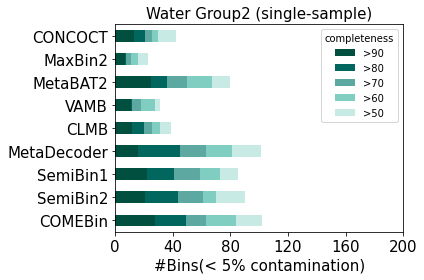

In [53]:
sample_list=['SRR9061277', 'SRR9061283', 'SRR9061370', 'SRR9061371','SRR9061376']

data_path='../results/real_data/watergroup2_singlesample'
output='./figures/watergroup2_singlesample_sum_checkm2_plot_all.pdf'
plot_bar_realdata_sum(sample_list, data_path,y_label=[0, 40, 80, 120, 160, 200], title='Water Group2 (single-sample)', output = output)


In [54]:
# watergroup2_multisample

             90  80  70  60  50
COMEBin      10   4   2   7  10
SemiBin2      6   5   5   3   5
SemiBin1      5   5   6   4   5
MetaDecoder   5   3   7   3   6
CLMB          2   5   1   4   5
VAMB          3   5   2   5   2
MetaBAT2      7   4   4   4   1
MaxBin2       3   0   0   2   2
CONCOCT       7   2   3   2   5
             90  80  70  60  50
COMEBin       7   4   1   3   7
SemiBin2      6   3   5   4   1
SemiBin1      4   3   6   5   3
MetaDecoder   4   3   5   3   5
CLMB          1   5   2   4   1
VAMB          2   3   6   2   1
MetaBAT2      5   5   3   2   7
MaxBin2       1   0   0   1   1
CONCOCT       3   1   2   1   3
             90  80  70  60  50
COMEBin       4   6   2   2   4
SemiBin2      0   4   3   5   7
SemiBin1      0   4   3   5   7
MetaDecoder   0   3   2   9   3
CLMB          0   1   0   2   4
VAMB          0   3   1   2   5
MetaBAT2      1   4   2   2   4
MaxBin2       0   0   1   1   1
CONCOCT       2   2   2   2   2
             90  80  70  60  50
COMEBin 

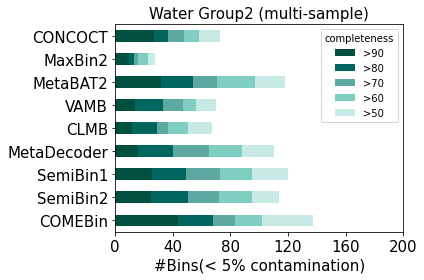

In [55]:
sample_list=['SRR9061277', 'SRR9061283', 'SRR9061370', 'SRR9061371','SRR9061376']

data_path='../results/real_data/watergroup2_multisample'
output='./figures/watergroup2_multisample_sum_checkm2_plot_all.pdf'
plot_bar_realdata_sum(sample_list, data_path,y_label=[0, 40, 80, 120, 160, 200], title='Water Group2 (multi-sample)', output = output)


In [56]:
# watergroup3_singlesample

             90  80  70  60  50
COMEBin       5   2   4   3   4
SemiBin2      2   3   4   2   5
SemiBin1      3   2   4   2   5
MetaDecoder   2   3   4   2   7
CLMB          0   0   0   0   0
VAMB          1   0   1   0   1
MetaBAT2      4   4   0   3   0
MaxBin2       1   0   1   0   4
CONCOCT       0   0   2   1   2
             90  80  70  60  50
COMEBin       3   4   6   3   8
SemiBin2      2   4   3   5   6
SemiBin1      2   4   4   5   5
MetaDecoder   2   5   5   1   6
CLMB          2   1   1   1   1
VAMB          1   1   0   0   0
MetaBAT2      3   7   4   3   1
MaxBin2       0   1   2   0   2
CONCOCT       4   3   1   2   0
             90  80  70  60  50
COMEBin       8   2   4   2   3
SemiBin2      2   5   3   4   4
SemiBin1      3   6   2   1   6
MetaDecoder   5   2   3   4   2
CLMB          2   1   1   1   3
VAMB          2   2   0   0   1
MetaBAT2      3   4   6   3   1
MaxBin2       2   1   1   0   0
CONCOCT       3   3   4   1   1
             90  80  70  60  50
COMEBin 

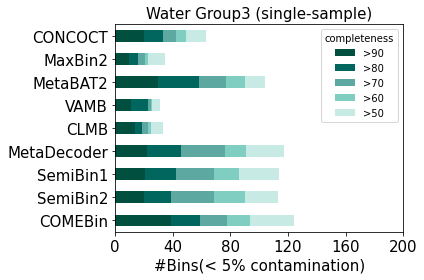

In [58]:
sample_list=['SRR9061270', 'SRR9061271', 'SRR9061273', 'SRR9061274',
             'SRR9061276', 'SRR9061286', 'SRR9061287']
data_path='../results/real_data/watergroup3_singlesample'
output='./figures/watergroup3_singlesample_sum_checkm2_plot_all.pdf'
plot_bar_realdata_sum(sample_list, data_path,y_label=[0, 40, 80, 120, 160, 200], title='Water Group3 (single-sample)', output = output)


In [59]:
# watergroup3_multisample

             90  80  70  60  50
COMEBin       5   2   6   3   6
SemiBin2      2   4   3   2   5
SemiBin1      2   5   3   2   4
MetaDecoder   1   1   0   4   2
CLMB          0   0   1   2   0
VAMB          0   0   1   2   2
MetaBAT2      0   4   1   1   2
MaxBin2       0   0   0   0   4
CONCOCT       0   1   2   3   1
             90  80  70  60  50
COMEBin       8   4   4   3   6
SemiBin2      4   2   8   5   4
SemiBin1      4   2   7   5   5
MetaDecoder   1   5   7   5   6
CLMB          1   3   4   2   4
VAMB          2   3   8   3   2
MetaBAT2      3   6   5   5   3
MaxBin2       2   0   0   0   4
CONCOCT       7   3   2   1   2
             90  80  70  60  50
COMEBin      11   4   2   3   5
SemiBin2      4   6   1   7   2
SemiBin1      4   6   1   6   2
MetaDecoder   5   6   2   7   2
CLMB          3   4   2   2   1
VAMB          4   2   5   4   1
MetaBAT2      7   4   5   4   2
MaxBin2       3   0   2   0   2
CONCOCT       8   4   4   1   4
             90  80  70  60  50
COMEBin 

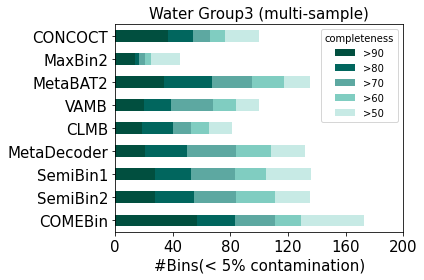

In [60]:
sample_list=['SRR9061270', 'SRR9061271', 'SRR9061273', 'SRR9061274',
             'SRR9061276', 'SRR9061286', 'SRR9061287']
data_path='../results/real_data/watergroup3_multisample'
output='./figures/watergroup3_multisample_sum_checkm2_plot_all.pdf'
plot_bar_realdata_sum(sample_list, data_path,y_label=[0, 40, 80, 120, 160, 200], title='Water Group3 (multi-sample)', output = output)


In [61]:
# Figure S7

In [62]:
"""
This script is used to reproduce the plot of the CAMI II results(compared to other binners).
Modified from https://github.com/BigDataBiology/SemiBin_benchmark/blob/main/visualization/CAMI_I_comparison.py
"""

import pandas as pd
import os
import matplotlib.pyplot as plt


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

color_map = ['#014f3f','#01665e', '#5da8a1', '#80cdc1', '#c7eae5']

def get_number_of_genomes_per_completeness(amber_path, return_pandas=False):
    genome_path = os.path.join(amber_path, 'genome')
    table = {}
    for root, dirs, files in os.walk(genome_path, topdown=False):
        for name in dirs:
            method_path = os.path.join(root, name)
            metric = pd.read_csv(os.path.join(method_path, 'metrics_per_bin.tsv'), sep='\t')
            metric = metric.query('`Purity (bp)` >= 0.95')
            com_90_pur_95 = metric.eval('`Completeness (bp)` > 0.9').sum()
            com_80_pur_95 = metric.eval('`Completeness (bp)` > 0.8').sum() - (
                com_90_pur_95)
            com_70_pur_95 = metric.eval('`Completeness (bp)` > 0.7').sum() - (
                    com_90_pur_95 + com_80_pur_95)
            com_60_pur_95 = metric.eval('`Completeness (bp)` > 0.6').sum() - (
                    com_90_pur_95 + com_80_pur_95 + com_70_pur_95)
            com_50_pur_95 = metric.eval('`Completeness (bp)` > 0.5').sum() - (
                    com_90_pur_95 + com_80_pur_95 + com_70_pur_95 + com_60_pur_95)
            table[method_path.split('/')[-1]]= [com_90_pur_95, com_80_pur_95, com_70_pur_95, com_60_pur_95, com_50_pur_95]
    if return_pandas:
        return pd.DataFrame(table, index=[90,80,70,60,50]).T
    return table

In [63]:
def plot_bar_elimination(amber_path, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness(amber_path, return_pandas=True)

    subset = data.loc[[
        'COMEBin',
        'COMEBin (SemiBin2 embeddings)',
        'COMEBin (SemiBin1 embeddings)',
        'COMEBin (CLMB embeddings)',
        'COMEBin (VAMB embeddings)',
        'COMEBin NoContrast (kmer)',
        'COMEBin NoContrast (coverage)',
        'COMEBin NoContrast (combine)']]

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=10, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=10, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=10, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()
    plt.close()
    


In [64]:
# CAMI Mouse gut

                                90  80  70  60  50
COMEBin                        516  35  27   7   6
COMEBin (SemiBin2 embeddings)  213  61  30  10  20
COMEBin (SemiBin1 embeddings)  334  82  36  22  16
COMEBin (CLMB embeddings)      288  76  29   7  12
COMEBin (VAMB embeddings)      366  56  22  17  12
COMEBin NoContrast (kmer)       56  15  10   7  10
COMEBin NoContrast (coverage)  317  69  24  11  16
COMEBin NoContrast (combine)   239  31  13   4   5
Improvement of best binner over second best: 40.98%


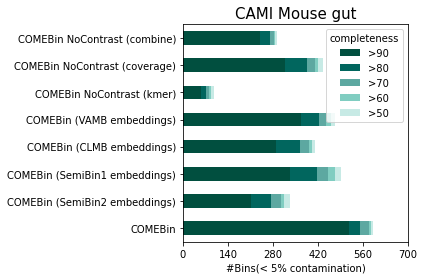

In [65]:
amber_path='../results/supp/amber_cami_mousegut_elimination'
output='./figures/cami_mousegut_elimination_amber_plot_bar.pdf'
plot_bar_elimination(amber_path, y_label=[0, 140, 280, 420, 560, 700], title='CAMI Mouse gut', output=output)


In [66]:
# CAMI Airways

                                90  80  70  60  50
COMEBin                        155  24  15  17  13
COMEBin (SemiBin2 embeddings)  123  20  12  13  20
COMEBin (SemiBin1 embeddings)  117  23   8  16  20
COMEBin (CLMB embeddings)      125  23  16  18  14
COMEBin (VAMB embeddings)      128  24  18  13  15
COMEBin NoContrast (kmer)       98  10   9  12   9
COMEBin NoContrast (coverage)  105  11   6  10   9
COMEBin NoContrast (combine)   103  20   9  14  11
Improvement of best binner over second best: 21.09%


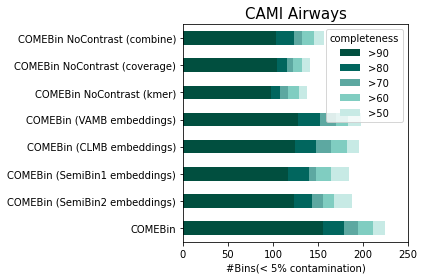

In [67]:
amber_path='../results/supp/amber_cami_airways_elimination'
output='./figures/cami_airways_elimination_amber_plot_bar.pdf'
plot_bar_elimination(amber_path, y_label=[0, 50, 100, 150, 200, 250], title='CAMI Airways', output=output)

In [68]:
# CAMI Gt

                                90  80  70  60  50
COMEBin                        156  20  13   3   8
COMEBin (SemiBin2 embeddings)  139  13  12   4   8
COMEBin (SemiBin1 embeddings)  136  13  10   4   9
COMEBin (CLMB embeddings)      136  17  13   7   8
COMEBin (VAMB embeddings)      137  18   8   4   8
COMEBin NoContrast (kmer)      110   8   9   3   9
COMEBin NoContrast (coverage)  114  10  11   2  10
COMEBin NoContrast (combine)   120  15  10   2   8
Improvement of best binner over second best: 12.23%


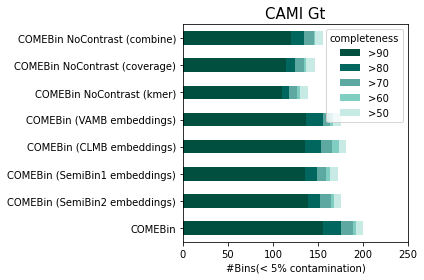

In [69]:
amber_path='../results/supp/amber_cami_gt_elimination'
output='./figures/cami_gt_elimination_amber_plot_bar.pdf'
plot_bar_elimination(amber_path, y_label=[0, 50, 100, 150, 200, 250], title='CAMI Gt', output=output)


In [70]:
# CAMI Skin

                                90  80  70  60  50
COMEBin                        200  22  13   8  15
COMEBin (SemiBin2 embeddings)  137  22   7  36  13
COMEBin (SemiBin1 embeddings)  129  22  13  36  15
COMEBin (CLMB embeddings)      138  22  24  14  15
COMEBin (VAMB embeddings)      145  27  18  15  14
COMEBin NoContrast (kmer)      114   9   7  15  17
COMEBin NoContrast (coverage)  114   4   3   9  11
COMEBin NoContrast (combine)   116  22  11  10  17
Improvement of best binner over second best: 37.93%


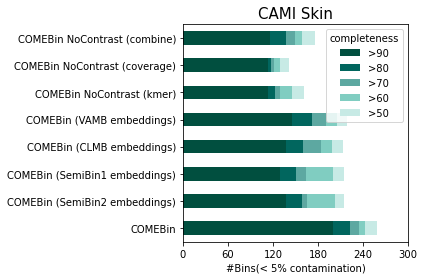

In [71]:
amber_path='../results/supp/amber_cami_skin_elimination'
output='./figures/cami_skin_elimination_amber_plot_bar.pdf'
plot_bar_elimination(amber_path, y_label=[0, 60, 120, 180, 240, 300], title='CAMI Skin', output=output)

In [73]:
def plot_bar_realdata_elimination(checkm2_res_file, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness_checkm2(checkm2_res_file, return_pandas=True)

    if 'combine_novars' in data.index:
        data = data.rename(index={'combine_novars': 'COMEBin NoContrast (combine)'})
    if 'covMat' in data.index:
        data = data.rename(index={'covMat': 'COMEBin NoContrast (coverage)'})
    if 'compositMat' in data.index:
        data = data.rename(index={'compositMat': 'COMEBin NoContrast (kmer)'})
    if 'COMEBIN_with_VAMB_embeddings_l2normaize' in data.index:
        data = data.rename(index={'COMEBIN_with_VAMB_embeddings_l2normaize': 'COMEBin (VAMB embeddings)'})
    if 'COMEBIN_with_CLMB_embeddings_l2normaize' in data.index:
        data = data.rename(index={'COMEBIN_with_CLMB_embeddings_l2normaize': 'COMEBin (CLMB embeddings)'})
    if 'COMEBIN_with_semibin_embeddings_l2normaize' in data.index:
        data = data.rename(index={'COMEBIN_with_semibin_embeddings_l2normaize': 'COMEBin (SemiBin2 embeddings)'})
    if 'COMEBIN_with_semibin1_embeddings_l2normaize' in data.index:
        data = data.rename(index={'COMEBIN_with_semibin1_embeddings_l2normaize': 'COMEBin (SemiBin1 embeddings)'})
    if 'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric' in data.index:
        data = data.rename(index={'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric': 'COMEBin'})


    subset = data.loc[[
        'COMEBin',
        'COMEBin (SemiBin2 embeddings)',
        'COMEBin (SemiBin1 embeddings)',
        'COMEBin (CLMB embeddings)',
        'COMEBin (VAMB embeddings)',
        'COMEBin NoContrast (kmer)',
        'COMEBin NoContrast (coverage)',
        'COMEBin NoContrast (combine)']]

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=10, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=10, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=10, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()
    plt.close()
    


In [74]:
# Water Group1

                               90  80  70  60  50
COMEBin                        22  11  15  13  14
COMEBin (SemiBin2 embeddings)  15  15   9   6  10
COMEBin (SemiBin1 embeddings)  10  13  16   9  13
COMEBin (CLMB embeddings)      10   8   4   4   6
COMEBin (VAMB embeddings)      16  10   5   8  13
COMEBin NoContrast (kmer)       1   1   2   6   3
COMEBin NoContrast (coverage)   2   2   1   2   2
COMEBin NoContrast (combine)    0   1   4   9   5
Improvement of best binner over second best: 37.50%


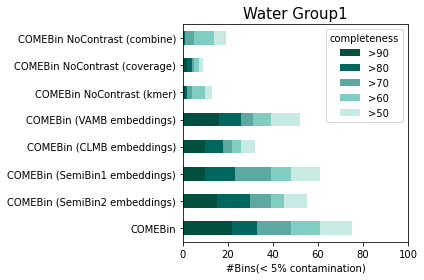

In [75]:
checkm2_res_file='../results/supp/real_data/elimination/watergroup1/checkm2_res_all_stat_res.tsv'
output='./figures/watergroup1_elimination_checkm2_plot_all.pdf'
plot_bar_realdata_elimination(checkm2_res_file, y_label=[0, 20, 40, 60, 80, 100], title='Water Group1', output=output)


In [76]:
# STEC

                               90  80  70  60  50
COMEBin                        37  37  36  31  22
COMEBin (SemiBin2 embeddings)   6  16  14  18  16
COMEBin (SemiBin1 embeddings)   9  19  19  22  15
COMEBin (CLMB embeddings)      31  31  22  24  22
COMEBin (VAMB embeddings)      28  31  31  23  17
COMEBin NoContrast (kmer)       0   3   5   2   9
COMEBin NoContrast (coverage)  16  29  12  15  11
COMEBin NoContrast (combine)   20  17  18  13  11
Improvement of best binner over second best: 19.35%


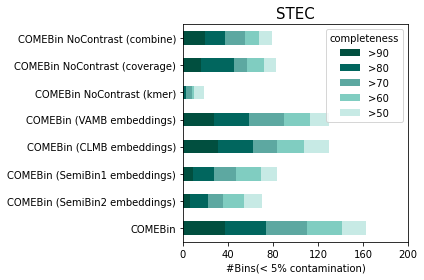

In [77]:
checkm2_res_file='../results/supp/real_data/elimination/STEC/checkm2_res_all_stat_res.tsv'
output='./figures/STEC_elimination_checkm2_plot_all.pdf'
plot_bar_realdata_elimination(checkm2_res_file, y_label=[0, 40, 80, 120, 160, 200], title='STEC', output=output)


In [78]:
## Figure S8

In [82]:

def plot_bar_multipleview(amber_path, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness(amber_path, return_pandas=True)

    subset = data.loc[[
        'COMEBin (8 view)',
        'COMEBin (6 view)',
        'COMEBin (4 view)',
        'COMEBin (2 view)']]

    subset.rename(index={
        'COMEBin (8 view)': 'COMEBin (8 views)',
        'COMEBin (6 view)': 'COMEBin (6 views)',
        'COMEBin (4 view)': 'COMEBin (4 views)',
        'COMEBin (2 view)': 'COMEBin (2 views)',
    }, inplace=True)

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=12, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=12, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=12, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()
    plt.close()


In [80]:
# CAMI Mouse gut

                    90  80  70  60  50
COMEBin (8 views)  513  38  28   6   4
COMEBin (6 views)  516  35  27   7   6
COMEBin (4 views)  495  41  24   7   5
COMEBin (2 views)  419  70  39  14  26
Improvement of best binner over second best: 0.58%


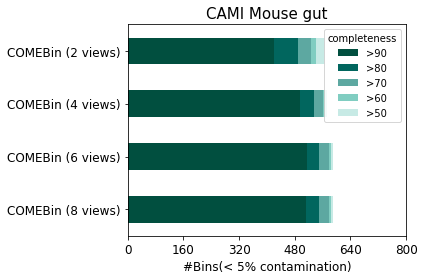

In [83]:
amber_path='../results/supp/amber_cami_mousegut_multiple_view'
output='./figures/cami_mousegut_multipleview_amber_plot_bar.pdf'
plot_bar_multipleview(amber_path, y_label=[0, 160, 320, 480, 640, 800], title='CAMI Mouse gut', output=output)


In [84]:
# CAMI Airways

                    90  80  70  60  50
COMEBin (8 views)  156  24  17  14  12
COMEBin (6 views)  155  24  15  17  13
COMEBin (4 views)  148  29  15  16  13
COMEBin (2 views)  150  23  13  12  10
Improvement of best binner over second best: 0.65%


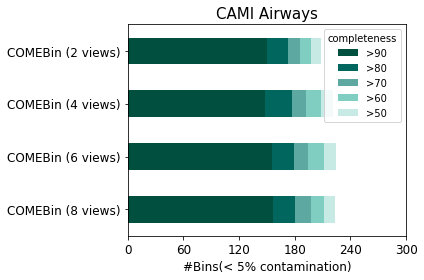

In [85]:
amber_path='../results/supp/amber_cami_airways_multiple_view'
output='./figures/cami_airways_multipleview_amber_plot_bar.pdf'
plot_bar_multipleview(amber_path, y_label=[0, 60, 120, 180, 240, 300], title='CAMI Airways', output=output)


In [86]:
# CAMI Gt

                    90  80  70  60  50
COMEBin (8 views)  163  16  12   1   8
COMEBin (6 views)  156  20  13   3   8
COMEBin (4 views)  156  17  13   3   8
COMEBin (2 views)  146  20  16   9   8
Improvement of best binner over second best: 4.49%


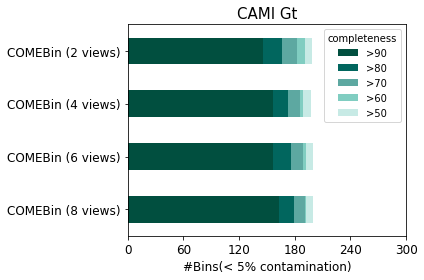

In [87]:
amber_path='../results/supp/amber_cami_gt_multiple_view'
output='./figures/cami_gt_multipleview_amber_plot_bar.pdf'
plot_bar_multipleview(amber_path, y_label=[0, 60, 120, 180, 240, 300], title='CAMI Gt', output=output)


In [88]:
# CAMI Skin

                    90  80  70  60  50
COMEBin (8 views)  200  24   8  11  12
COMEBin (6 views)  200  22  13   8  15
COMEBin (4 views)  183  26  23  21  14
COMEBin (2 views)  173  27  17  16  13
Improvement of best binner over second best: 0.00%


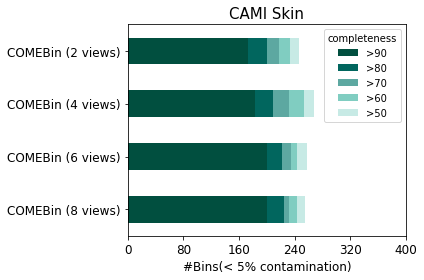

In [89]:
amber_path='../results/supp/amber_cami_skin_multiple_view'
output='./figures/cami_skin_multipleview_amber_plot_bar.pdf'
plot_bar_multipleview(amber_path, y_label=[0, 80, 160, 240, 320, 400], title='CAMI Skin', output=output)

In [91]:
def plot_bar_realdata_multipleview(checkm2_res_file, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness_checkm2(checkm2_res_file, return_pandas=True)

    subset = data.loc[[
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric_8view',
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric',
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric_4view',
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric_2view'
        ]]
    subset.rename(index={
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric':'COMEBin (6 views)',
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric_2view': 'COMEBin (2 views)',
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric_4view': 'COMEBin (4 views)',
        'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric_8view': 'COMEBin (8 views)',
    }, inplace=True)

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=12, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=12, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=12, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()
    plt.close()
    

In [92]:
# STEC

                   90  80  70  60  50
COMEBin (8 views)  34  41  25  32  24
COMEBin (6 views)  37  37  36  31  22
COMEBin (4 views)  34  40  31  30  25
COMEBin (2 views)  34  36  31  27  28
Improvement of best binner over second best: 8.82%


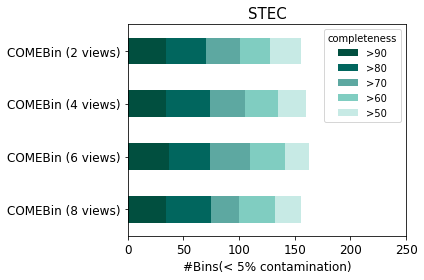

In [93]:
checkm2_res_file='../results/supp/real_data/multiple_view/STEC/checkm2_res_all_stat_res.tsv'
output='./figures/STEC_multiple_view_checkm2_plot_all.pdf'
plot_bar_realdata_multipleview(checkm2_res_file, y_label=[0, 50, 100, 150, 200, 250], title='STEC', output=output)


In [94]:
# Water Group1

                   90  80  70  60  50
COMEBin (8 views)  22  11   7  12  18
COMEBin (6 views)  22  11  15  13  14
COMEBin (4 views)  22  12  15  12  16
COMEBin (2 views)  22   9  14  13  14
Improvement of best binner over second best: 0.00%


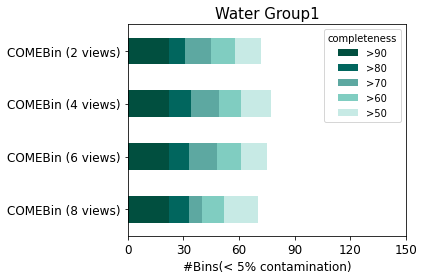

In [95]:
checkm2_res_file='../results/supp/real_data/multiple_view/watergroup1/checkm2_res_all_stat_res.tsv'
output='./figures/watergroup1_multiple_view_checkm2_plot_all.pdf'
plot_bar_realdata_multipleview(checkm2_res_file, y_label=[0, 30, 60, 90, 120, 150], title='Water Group1', output=output)


In [97]:
# Figure S9

In [104]:
def plot_bar_realdata_longread(checkm2_res_file, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness_checkm2(checkm2_res_file, return_pandas=True)

    if 'metabat2_bins_checkm2_output' in data.index:
        data = data.rename(index={'metabat2_bins_checkm2_output': 'MetaBAT2'})
    if 'metadecoder' in data.index:
        data = data.rename(index={'metadecoder': 'MetaDecoder'})
    if 'semibin2_Easy_coassemly_mode_metawrapalign' in data.index:
        data = data.rename(index={'semibin2_Easy_coassemly_mode_metawrapalign': 'SemiBin2'})
    if 'semibin2_Easy_coassemly_mode_metawrapalign_sequencing_type_long_read' in data.index:
        data = data.rename(index={'semibin2_Easy_coassemly_mode_metawrapalign_sequencing_type_long_read': 'SemiBin2_long_read_mode'})
    if 'comebin_res' in data.index:
        data = data.rename(index={'comebin_res': 'COMEBin'})


    subset = data.loc[[
        'COMEBin',
        'SemiBin2',
        'SemiBin2_long_read_mode',
        'MetaDecoder',
        'MetaBAT2']]

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60', '>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=12, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=12, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=12, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()
    plt.close()


    return subset



In [100]:
# CRR344871

                         90  80  70  60  50
COMEBin                  27   6   6   4   2
SemiBin2                 17   3   4   3   5
SemiBin2_long_read_mode  29   5   2   5   4
MetaDecoder              27   6   2   5   4
MetaBAT2                 21   3   7   4   9
Improvement of best binner over second best: 7.41%


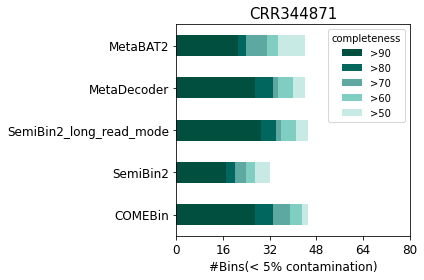

In [105]:
checkm2_res_file='../results/supp/real_data/long_read/CRR344871/checkm2_res_all_stat_res.tsv'
output='./figures/CRR344871_checkm2_plot_all.pdf'
CRR344871_subset = plot_bar_realdata_longread(checkm2_res_file, y_label=[0, 16, 32, 48, 64, 80], title='CRR344871', output=output)


In [106]:
# CRR344872

                         90  80  70  60  50
COMEBin                  35   5   4   1   2
SemiBin2                 33   4   5   2   3
SemiBin2_long_read_mode  43   2   6   1   0
MetaDecoder              39   3   3   0   4
MetaBAT2                 33   3   4   2   6
Improvement of best binner over second best: 10.26%


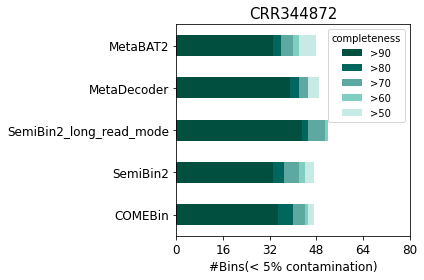

In [107]:
checkm2_res_file='../results/supp/real_data/long_read/CRR344872/checkm2_res_all_stat_res.tsv'
output='./figures/CRR344872_checkm2_plot_all.pdf'
CRR344872_subset = plot_bar_realdata_longread(checkm2_res_file, y_label=[0, 16, 32, 48, 64, 80], title='CRR344872', output=output)


In [109]:
# SRR10963010

                          90  80  70  60  50
COMEBin                  176  44  27  22  33
SemiBin2                 151  37  13  20  17
SemiBin2_long_read_mode  183  57  23  35  32
MetaDecoder              165  37  28  28  51
MetaBAT2                 106  26  19  32  33
Improvement of best binner over second best: 3.98%


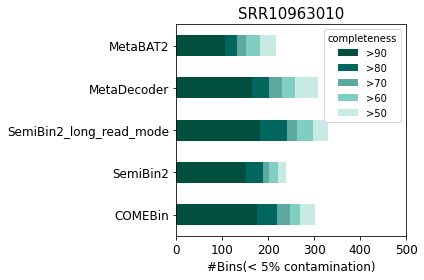

In [110]:
checkm2_res_file='../results/supp/real_data/long_read/SRR10963010/checkm2_res_all_stat_res.tsv'
output='./figures/SRR10963010_checkm2_plot_all.pdf'
SRR10963010_subset = plot_bar_realdata_longread(checkm2_res_file, y_label=[0, 100, 200, 300, 400, 500], title='SRR10963010', output=output)


In [112]:
# ERR9769275

                         90  80  70  60  50
COMEBin                   5   2   4   3  13
SemiBin2                  3   5   3   5   7
SemiBin2_long_read_mode   5   4   9   4   8
MetaDecoder               3   1   3   7   5
MetaBAT2                  1   3   1   2   3
Improvement of best binner over second best: 0.00%


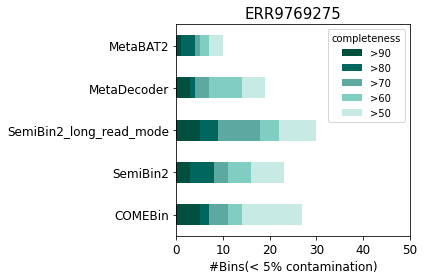

In [113]:
checkm2_res_file='../results/supp/real_data/long_read/ERR9769275/checkm2_res_all_stat_res.tsv'
output='./figures/ERR9769275_checkm2_plot_all.pdf'
ERR9769275_subset = plot_bar_realdata_longread(checkm2_res_file, y_label=[0, 10, 20, 30, 40, 50], title='ERR9769275', output=output)


In [114]:
## Figure S10

In [121]:
def plot_bar(amber_path, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness(amber_path, return_pandas=True)

    if 'COMEBin_filter200000' in data.index:
            data = data.rename(index={'COMEBin_filter200000': 'COMEBin'})
    elif 'COMEBin(filter200000)' in data.index:
            data = data.rename(index={'COMEBin(filter200000)': 'COMEBin'})
    elif 'COMEBinfilterminszie200000' in data.index:
        data = data.rename(index={'COMEBinfilterminszie200000': 'COMEBin'})

    if 'Metadecoder' in data.index:
        data = data.rename(index={'Metadecoder': 'MetaDecoder'})

    subset = data.loc[[
    'COMEBin',
    'SemiBin2',
    'SemiBin1',
    'MetaDecoder',
    'CLMB',
    'VAMB_v413',
    'MetaBAT',
    'MaxBin',
    'CONCOCT']]

    subset.rename(index={
        'MaxBin': 'MaxBin2',
        'MetaBAT': 'MetaBAT2',
        'VAMB_v413': 'VAMB',
    }, inplace=True)

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=15, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=15, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=15, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()

def plot_bar_novamb(amber_path, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness(amber_path, return_pandas=True)

    if 'COMEBin_filter200000' in data.index:
            data = data.rename(index={'COMEBin_filter200000': 'COMEBin'})
    elif 'COMEBin(filter200000)' in data.index:
            data = data.rename(index={'COMEBin(filter200000)': 'COMEBin'})
    elif 'COMEBinfilterminszie200000' in data.index:
        data = data.rename(index={'COMEBinfilterminszie200000': 'COMEBin'})

    if 'Metadecoder' in data.index:
        data = data.rename(index={'Metadecoder': 'MetaDecoder'})

    subset = data.loc[[
    'COMEBin',
    'SemiBin2',
    'SemiBin1',
    'MetaDecoder',
    'CLMB',
    'MetaBAT',
    'MaxBin',
    'CONCOCT']]

    subset.rename(index={
        'MaxBin': 'MaxBin2',
        'MetaBAT': 'MetaBAT2',
    }, inplace=True)

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=15, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=15, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=15, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()





In [116]:
# CAMI Mouse gut (10-genome)

             90  80  70  60  50
COMEBin       5   0   1   1   1
SemiBin2      3   0   1   1   1
SemiBin1      5   1   0   3   0
MetaDecoder   4   1   0   2   1
CLMB          3   2   0   0   1
MetaBAT2      3   1   2   0   0
MaxBin2       3   1   0   0   0
CONCOCT       5   3   0   0   0
Improvement of best binner over second best: 0.00%


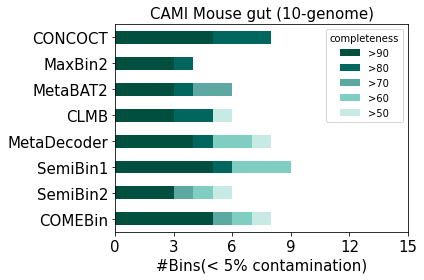

In [122]:
amber_path='../results/supp/amber_cami_mousegut_subsample_10genome_all'
output='./figures/cami_mousegut_subsample_10genome_amber_all.pdf'
plot_bar_novamb(amber_path, y_label=[0, 3, 6, 9, 12, 15], title='CAMI Mouse gut (10-genome)', output=output)


In [123]:
# CAMI Skin (10-genome)

             90  80  70  60  50
COMEBin       5   0   1   1   0
SemiBin2      1   0   1   0   0
SemiBin1      2   0   1   0   0
MetaDecoder   3   0   1   0   0
CLMB          4   0   0   0   0
VAMB          3   0   0   0   1
MetaBAT2      1   2   0   3   0
MaxBin2       2   0   1   0   0
CONCOCT       3   2   2   0   0
Improvement of best binner over second best: 25.00%


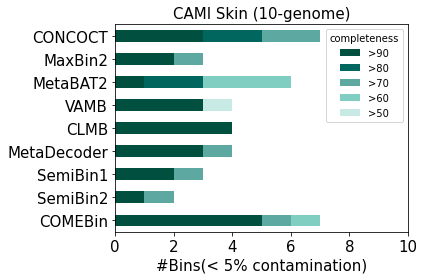

In [124]:
amber_path='../results/supp/amber_cami_skin_subsample_10genome_all'
output='./figures/cami_skin_subsample_10genomeamber_all.pdf'
plot_bar(amber_path, y_label=[0, 2, 4, 6, 8, 10], title='CAMI Skin (10-genome)', output=output)


In [125]:
## Figures S11, S12

In [128]:
import matplotlib.pyplot as plt

def plot_length_distribution(data,labels,out_file):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(labels))

    for label, values in data.items():
        ax.plot(x, values, label=label, marker='o')

    ax.set_ylabel('Count')
    ax.set_title('Statistics of contigs for real datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()


    plt.tight_layout()
    plt.savefig(out_file, dpi=300)
    plt.show()


def count_sequence_lengths(fasta_files, length_thresholds, file_names):
    data = {}

    for idx, file in enumerate(fasta_files):
        file_name = file_names[idx]
        data[file_name] = [0] * len(length_thresholds)

        with open(file, 'r') as f:
            sequence = ''
            for line in f:
                if line.startswith('>'):
                    if sequence:
                        length = len(sequence)
                        for i, threshold in enumerate(length_thresholds):
                            if length >= threshold:
                                data[file_name][i] += 1
                    sequence = ''
                else:
                    sequence += line.strip()

            # Check the last sequence
            if sequence:
                length = len(sequence)
                for i, threshold in enumerate(length_thresholds):
                    if length >= threshold:
                        data[file_name][i] += 1

    return data


In [127]:
# Simulated datasets

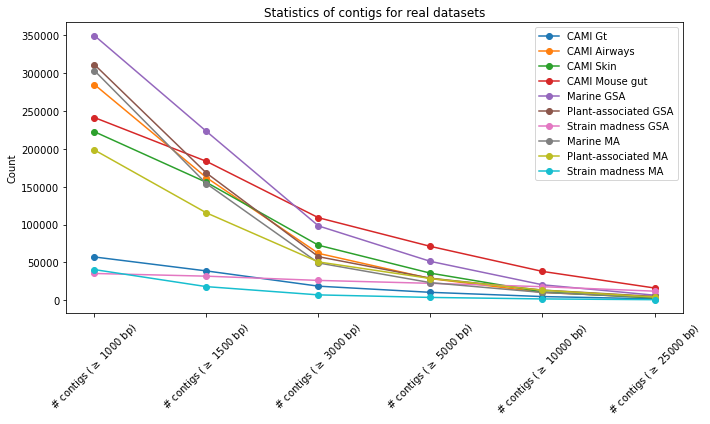

In [130]:
length_thresholds = [1000, 1500, 3000, 5000, 10000, 25000]
labels = ['# contigs ($\geq$ 1000 bp)', '# contigs ($\geq$ 1500 bp)','# contigs ($\geq$ 3000 bp)',
          '# contigs ($\geq$ 5000 bp)', '# contigs ($\geq$ 10000 bp)',
          '# contigs ($\geq$ 25000 bp)',]

fasta_files = ['../results/supp/seqs/cami_gt/sequences_aug0.fasta',
               '../results/supp/seqs/cami_10sample/sequences_aug0.fasta',
               '../results/supp/seqs/cami_skin/sequences_aug0.fasta',
               '../results/supp/seqs/cami_mousegut/sequences_aug0.fasta',
               '../results/supp/seqs/camimarine_shortread_gold_assembly/sequences_aug0.fasta',
               '../results/supp/seqs/plant_associated_dataset_gold_assembly/sequences_aug0.fasta',
               '../results/supp/seqs/camistrainmadness_shortread_gold_assembly/sequences_aug0.fasta',
               '../results/supp/seqs/camimarine_shortread_megahit_assembly/sequences_aug0.fasta',
               '../results/supp/seqs/plant_associated_dataset_megahit_assembly/sequences_aug0.fasta',
               '../results/supp/seqs/camistrainmadness_shortread_megahit_assembly/sequences_aug0.fasta']

file_names = ["CAMI Gt","CAMI Airways","CAMI Skin","CAMI Mouse gut",
              "Marine GSA", "Plant-associated GSA","Strain madness GSA",
              "Marine MA", "Plant-associated MA","Strain madness MA"]

data = count_sequence_lengths(fasta_files, length_thresholds,file_names)


out_file='./figures/simulated_datasets_plot_sequence_length_distribution.pdf'
plot_length_distribution(data,labels,out_file)


In [131]:
# Real datasets

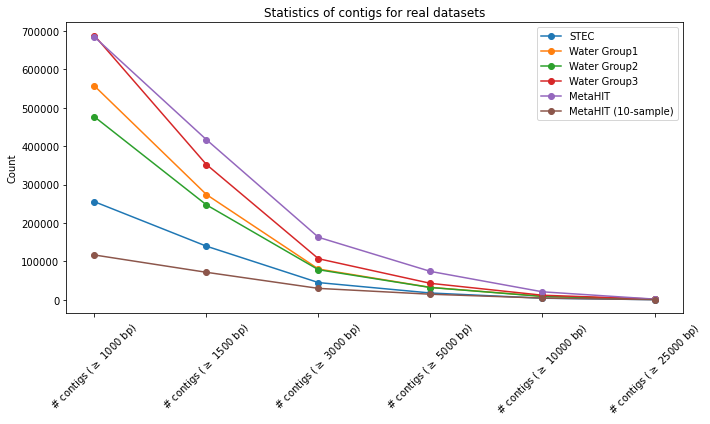

In [132]:
length_thresholds = [1000, 1500, 3000, 5000, 10000, 25000]
labels = ['# contigs ($\geq$ 1000 bp)', '# contigs ($\geq$ 1500 bp)','# contigs ($\geq$ 3000 bp)',
          '# contigs ($\geq$ 5000 bp)', '# contigs ($\geq$ 10000 bp)',
          '# contigs ($\geq$ 25000 bp)',]

fasta_files = ['../results/supp/seqs/STEC/sequences_aug0.fasta',
               '../results/supp/seqs/watergroup1/sequences_aug0.fasta',
               '../results/supp/seqs/watergroup2/sequences_aug0.fasta',
               '../results/supp/seqs/watergroup3/sequences_aug0.fasta',
               '../results/supp/seqs/MetaHIT/sequences_aug0.fasta',
               '../results/supp/seqs/MetaHIT_coassembly_10sample/sequences_aug0.fasta']

file_names = ["STEC","Water Group1","Water Group2","Water Group3",
              "MetaHIT","MetaHIT (10-sample)"]

data = count_sequence_lengths(fasta_files, length_thresholds,file_names)

out_file='./figures/real_datasets_plot_sequence_length_distribution.pdf'
plot_length_distribution(data,labels,out_file)

In [133]:
# Figure 13

In [134]:
def plot_bar_elimination_clustering_method(amber_path, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness(amber_path, return_pandas=True)

    subset = data.loc[[
        'COMEBin',
        'COMEBin (Infomap)',
        'SemiBin2 (no-recluster)',
        'COMEBin (weighted k-means)',
        'COMEBin (k-means)']]

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=10, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=10, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=10, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()


In [135]:
# CAMI Mouse gut

                             90  80  70  60  50
COMEBin                     516  35  27   7   6
COMEBin (Infomap)           406  60  41  28  15
SemiBin2 (no-recluster)     226  30  19  15  11
COMEBin (weighted k-means)  213  20   8  12  22
COMEBin (k-means)           125   5   7  15  25
Improvement of best binner over second best: 27.09%


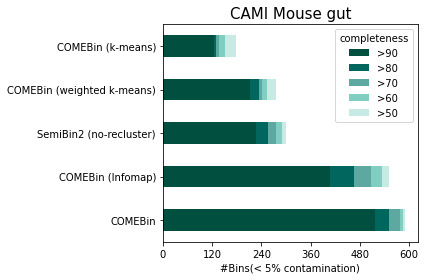

In [137]:
amber_path='../results/supp/amber_cami_mousegut_elimination'
output='./figures/cami_mousegut_elimination_clustering_method_amber_plot_bar.pdf'
plot_bar_elimination_clustering_method(amber_path, y_label=[0, 120, 240, 360, 480, 600], title='CAMI Mouse gut', output=output)


In [138]:
# CAMI Airways

                             90  80  70  60  50
COMEBin                     155  24  15  17  13
COMEBin (Infomap)            73  33  12   9   8
SemiBin2 (no-recluster)      52  10   3  18  12
COMEBin (weighted k-means)   60   9  10   7   8
COMEBin (k-means)            17  10   3   6   7
Improvement of best binner over second best: 112.33%


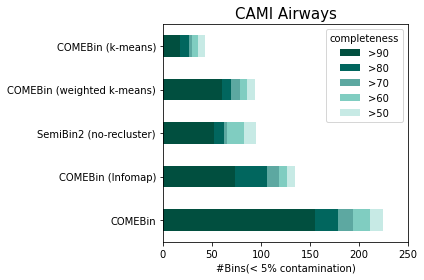

In [139]:
amber_path='../results/supp/amber_cami_airways_elimination'
output='./figures/cami_airways_elimination_clustering_method_amber_plot_bar.pdf'
plot_bar_elimination_clustering_method(amber_path, y_label=[0, 50, 100, 150, 200, 250], title='CAMI Airways', output=output)


In [140]:
# CAMI Gt

                             90  80  70  60  50
COMEBin                     156  20  13   3   8
COMEBin (Infomap)            70  15   8   3   3
SemiBin2 (no-recluster)      54   5   7   1   1
COMEBin (weighted k-means)   63   2   1   1   4
COMEBin (k-means)             8   0   3   0   5
Improvement of best binner over second best: 122.86%


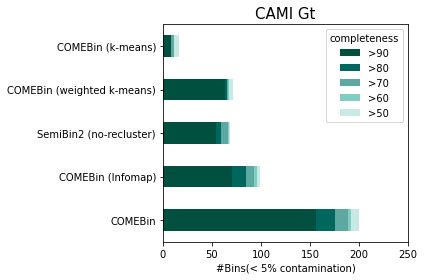

In [141]:
amber_path='../results/supp/amber_cami_gt_elimination'
output='./figures/cami_gt_elimination_clustering_method_amber_plot_bar.pdf'
plot_bar_elimination_clustering_method(amber_path, y_label=[0, 50, 100, 150, 200, 250], title='CAMI Gt', output=output)


In [142]:
# CAMI Skin

                             90  80  70  60  50
COMEBin                     200  22  13   8  15
COMEBin (Infomap)            96  29  16   8  10
SemiBin2 (no-recluster)      45  18   6  23   7
COMEBin (weighted k-means)   71  13  10  12  11
COMEBin (k-means)            22  14   6   5   9
Improvement of best binner over second best: 108.33%


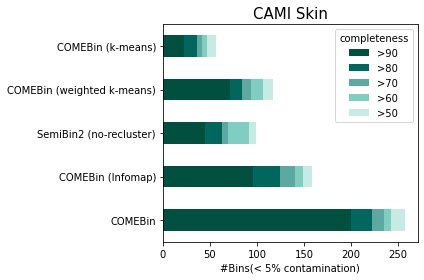

In [143]:
amber_path='../results/supp/amber_cami_skin_elimination'
output='./figures/cami_skin_elimination_clustering_method_amber_plot_bar.pdf'
plot_bar_elimination_clustering_method(amber_path, y_label=[0, 50, 100, 150, 200, 250], title='CAMI Skin', output=output)


In [148]:
def plot_bar_realdata_elimination_clustering_method(checkm2_res_file, add_legend=True,y_label = None,title = None, output = None):
    data = get_number_of_genomes_per_completeness_checkm2(checkm2_res_file, return_pandas=True)

    if 'cluster_infomap' in data.index:
        data = data.rename(index={'cluster_infomap': 'COMEBin (Infomap)'})
    if 'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric' in data.index:
        data = data.rename(index={'COMEBin_nocovloss_tau0.15_nepoch200_earlystop_addvars_nedge75_vars_sqrt_NokmerMetric': 'COMEBin'})
    if 'semibin2_Easy_coassemly_mode_no_recluster' in data.index:
        data = data.rename(index={'semibin2_Easy_coassemly_mode_no_recluster': 'SemiBin2 (no-recluster)'})
    if 'kmeans' in data.index:
        data = data.rename(index={'kmeans': 'COMEBin (k-means)'})
    if 'weight_kmeans' in data.index:
        data = data.rename(index={'weight_kmeans': 'COMEBin (weighted k-means)'})

    subset = data.loc[[
        'COMEBin',
        'COMEBin (Infomap)',
        'SemiBin2 (no-recluster)',
        'COMEBin (weighted k-means)',
        'COMEBin (k-means)'
]]

    subset = subset[[90,80,70,60,50]]
    print(subset)
    high_quality_list = subset[90].sort_values().values
    print('Improvement of best binner over second best: {:.2%}'.format(
        (high_quality_list[-1] - high_quality_list[-2]) / high_quality_list[-2]))
    ax = subset.plot(kind="barh", stacked=True, legend=False, color=color_map)

    if add_legend:
        ax.legend(['>90', '>80', '>70', '>60','>50'],
                  loc='upper right', fontsize=10, title='completeness')
    ax.set_xticks(ticks=y_label)
    ax.set_xticklabels(labels=y_label, fontsize=10, color='black')
    ax.set_yticklabels(labels=subset.index, fontsize=10, color='black')
    ax.set_xlabel('#Bins(< 5% contamination)', fontsize=10, color='black')
    ax.set_title(title, fontsize=15, alpha=1.0)

    plt.tight_layout()
    plt.savefig(output, dpi=300)
    plt.show()


In [145]:
# STEC

                            90  80  70  60  50
COMEBin                     37  37  36  31  22
COMEBin (Infomap)           22  29  28  40  33
SemiBin2 (no-recluster)      9  16  14  21  18
COMEBin (weighted k-means)  32  30  17   9   7
COMEBin (k-means)           22  23  17   8   9
Improvement of best binner over second best: 15.62%


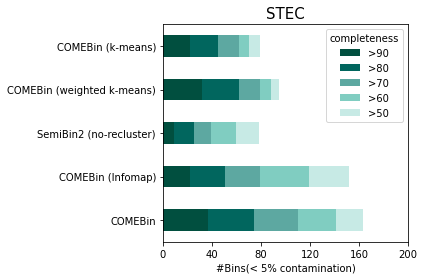

In [152]:
checkm2_res_file='../results/supp/real_data/elimination/STEC/checkm2_res_all_stat_res.tsv'
output='./figures/STEC_elimination_clustering_method_checkm2_plot_all.pdf'
plot_bar_realdata_elimination_clustering_method(checkm2_res_file, y_label=[0, 40, 80, 120, 160, 200], title='STEC', output=output)


In [150]:
# WaterGroup1

                            90  80  70  60  50
COMEBin                     22  11  15  13  14
COMEBin (Infomap)           23   8  14  14  12
SemiBin2 (no-recluster)     19  11  12  13  11
COMEBin (weighted k-means)   8   3   1   2   2
COMEBin (k-means)            1   2   1   3   1
Improvement of best binner over second best: 4.55%


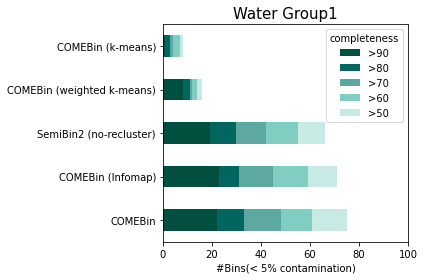

In [151]:
checkm2_res_file='../results/supp/real_data/elimination/watergroup1/checkm2_res_all_stat_res.tsv'
output='./figures/watergroup1_elimination_clustering_method_checkm2_plot_all.pdf'
plot_bar_realdata_elimination_clustering_method(checkm2_res_file, y_label=[0, 20, 40, 60, 80, 100], title='Water Group1', output=output)
